# Compute foraging behavior
### a) Validate with proteomics
### b) Inverse: estimate environment probabilities from foraging proteomics/transcriptome

### Forward
$$
\begin{align}
\max_{v^k,e}  \quad & f^T e + \sum_k p^k (c^T v^k) \\
\mathrm{s.t.} \quad & S^k v^k = 0 \\
                    & \sum_j e_j \leq P \\
                    & \sum_j e^k_j \leq P^k \\
                    & e^k_j = e_j + \delta_j^k \\
                    & v^k_j \leq k^\mathrm{eff}_j \cdot e_j \\
                    & l^k \leq v^k \leq u^k \\
                    & e \geq 0
\end{align}
$$

## With expression deviation constraints/objective

## Regulatory constraints
1. Parsimonious regulator 

1. Function of flux
$$
\begin{align}
& p_j = \sum_i \alpha_{ij} v_j
\end{align}
$$

In [1]:
from gurobipy import *

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

from cobra.io import load_json_model
from six import iteritems
import numpy as np
import cobra

In [2]:
from dynamicme.optimize import StackOptimizer

In [3]:
mdl0 = load_json_model('/home/laurence/ME/models/e_coli_core_mm.json')
crowd0 = mdl0.metabolites.crowding

## Environment probabilities

In [4]:
# Uniform
import json
with open('/home/laurence/python_modules/stressme.git/stressme/data/cnps/cnps_conds.json') as f:
    cnps = json.load(f)
with open('/home/laurence/python_modules/stressme.git/stressme/data/cnps/media_exchanges.json') as f:
    cnps_rxns = json.load(f)

In [5]:
conds = cnps['C']

In [6]:
rows = []
for csrc in conds:
    ex_rxn = cnps_rxns[csrc]
    if mdl0.reactions.has_id(ex_rxn):
        # Reset all other ex rxns to zero
        for csrcj in cnps['C']:
            ex_rxnj = cnps_rxns[csrcj]
            if mdl0.reactions.has_id(ex_rxnj):
                rows.append({'cond':csrc, 'rxn':ex_rxnj, 'lb':0., 'ub':1000., 'obj':0.})
        if csrc=='Acetate':
            lb = -20.
        else:
            lb = -10.
        if mdl0.reactions.has_id(ex_rxn):
            rows.append({'cond':csrc, 'rxn':ex_rxn, 'lb':lb, 'ub':1000., 'obj':0.})

In [7]:
df_conds = pd.DataFrame(rows)
df_X = df_conds
conds = df_X.cond.unique()

## Drop infeasible conds

In [8]:
stat_dict = {}
for cond in conds:
    dfi = df_conds[ df_conds.cond==cond]
    for i,row in dfi.iterrows():
        rid = row['rxn']
        rxn = mdl0.reactions.get_by_id(rid)
        rxn.lower_bound = row['lb']
        rxn.upper_bound = row['ub']
    mdl0.optimize()
    stat_dict[cond] = mdl0.solution.status

In [9]:
for ind,stat in iteritems(stat_dict):
    if stat != 'optimal':
        df_X = df_X[ df_X.cond != ind]
conds = df_X.cond.unique()

In [10]:
len(df_X.cond.unique())

13

In [11]:
from dynamicme.decomposition.LagrangeSubmodel import LagrangeSubmodel
from dynamicme.decomposition.LagrangeMaster import LagrangeMaster
from dynamicme.optimize import StackOptimizer

## Full-space model

In [12]:
stacker = StackOptimizer()
stacker.stack_models(mdl0, df_X)

In [13]:
from dynamicme.optimize import clone_attributes
from dynamicme.optimize import Variable, Constraint

es0 = mdl0.reactions.query('^e_')
es  = []
for e0j in es0:
    ej = Variable(e0j.id)
    clone_attributes(e0j, ej)
    es.append(ej)

stacker.model.add_reactions(es)

crowd0 = mdl0.metabolites.crowding
P_cap = crowd0._bound

dps = []
for ej in es:
    ### Add sum_j mwj*ej <= P
    cons = Constraint('crowding')
    cons._constraint_sense = 'L'
    cons._bound = P_cap
    e0 = mdl0.reactions.get_by_id(ej.id)
    mwj = e0.metabolites[crowd0]
    ej.add_metabolites({cons:mwj})
    for ind,mdli in iteritems(stacker.model_dict):            
        ejk = stacker.model.reactions.get_by_id("%s_%s"%(ej.id, ind))        
        ### Add some flexibility to respond within each condition
        # ejk = ej0 + dejk
        # ejk - ej0 - dejk = 0
        dejk = Variable('de_%s_%s'%(ej.id,ind), lower_bound=-1000, upper_bound=1000)
        stacker.model.add_reaction(dejk)
        cons = Constraint('prot_response_%s_%s'%(ej.id, ind))
        cons._constraint_sense = 'E'
        cons._bound = 0
        stacker.model.add_metabolites(cons)
        dejk.add_metabolites({cons:-1.})
        ej.add_metabolites({cons:-1.})
        ejk.add_metabolites({cons:1.})

In [14]:
stacker.model.optimize(solver='gurobi')

<Solution 6.11 at 0x7f2184a88ad0>

## Sample across proteome response capacities

In [259]:
N_SAMPLES = 10
DPs = np.linspace(0, 0.1, N_SAMPLES)
#DPs = [0]
mu_id = 'BIOMASS_Ecoli_core_w_GAM'
rows = []

for DP in DPs:
    for ind,mdli in iteritems(stacker.model_dict):
        for ej in es:
            dejk = stacker.model.reactions.get_by_id('de_%s_%s'%(ej.id,ind))
            dejk.lower_bound = -DP
            dejk.upper_bound = DP
            
    stacker.model.optimize(solver='gurobi', tolerance_feasibility=1e-9)
    
    if stacker.model.solution is not None and stacker.model.solution.status == 'optimal':
        mu_tot = stacker.model.solution.f
        stat = stacker.model.solution.status
        x_dict = stacker.model.solution.x_dict
        for ej in es:
            for ind in stacker.model_dict.keys():
                ejk = stacker.model.reactions.get_by_id('%s_%s'%(ej.id, ind))
                dejk = stacker.model.reactions.get_by_id('de_%s_%s'%(ej.id,ind))
                mu_rxnk = stacker.model.reactions.get_by_id('%s_%s'%(mu_id, ind))
                muk = x_dict[mu_rxnk.id]
                rows.append(
                    {'dp_max':DP, 'mu_tot':mu_tot, 'stat':stat, 'protein':ej.id, 'cond':ind,
                     'e0':x_dict[ej.id], 'ek':x_dict[ejk.id],
                     'dek':x_dict[dejk.id], 'muk':muk})
    else:
        mu_tot = np.nan
        stat = 'infeasible'
        rows.append({'dp_max':DP, 'mu_tot':mu_tot, 'stat':stat, 'protein':np.nan, 'cond':np.nan,
                     'e0':np.nan, 'ek':np.nan, 'dek':np.nan, 'muk':np.nan})

In [260]:
# from cobra.solvers import gurobi_solver
# solver = gurobi_solver.create_problem(stacker.model)
# solver.Params.FeasibilityTol = 1e-9
# solver.Params.OptimalityTol = 1e-9
# solver.optimize()
# sol = gurobi_solver.format_solution(solver, stacker.model)
# stacker.model.solution = sol

In [261]:
df_result = pd.DataFrame(rows)

In [262]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [263]:
df_result.shape

(5980, 9)

In [264]:
df_result[ (df_result.dp_max==dp_maxs[1]) & (df_result.protein=='e_ACALD')]

,cond,dek,dp_max,e0,ek,mu_tot,muk,protein,stat


In [265]:
df_result.head(2)

,cond,dek,dp_max,e0,ek,mu_tot,muk,protein,stat
0,Fumarate,-0.0,0.0,0.000679,0.000679,3.60841,0.366792,e_ACALD,optimal
1,L-Glutamate,-0.0,0.0,0.000679,0.000679,3.60841,0.598450,e_ACALD,optimal


In [267]:
table = df_result.pivot_table(index=['cond','dp_max'], columns='protein', values='ek')

In [268]:
from sklearn import preprocessing

In [269]:
Z_AXIS = 1   # Z-score'd proteome for each cond
pca = PCA()
X = table.values
Z = preprocessing.scale(X, axis=Z_AXIS)

Z_new = pca.fit_transform(Z)

In [270]:
Z_new.shape

(130, 46)

In [271]:
dp_maxs = [ix[1] for ix in table.index]

In [272]:
dsplot = pd.DataFrame.from_dict({'PC1':Z_new[:,0], 'PC2':Z_new[:,1], 'dp_max':dp_maxs})

In [273]:
Z.shape

(130, 46)

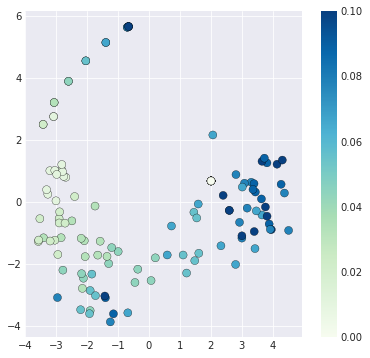

In [274]:
sns.set_style('darkgrid')

labels = set(dp_maxs)
n_labels = len(labels)
cmap_id = 'GnBu'
cmap = sns.color_palette(cmap_id, n_labels)

#g = sns.FacetGrid(dsplot, size=5, hue='dp_max', palette=cmap)
#g.map(plt.scatter, 'PC1','PC2', cmap=cmap)
# for ax in g.axes.flat:
#     pass
sns.set_palette(cmap)
pts = plt.scatter(dsplot.PC1, dsplot.PC2, c=dsplot.dp_max, cmap=cmap_id, edgecolor='#000000', lw=0.3, s=64)
#sns.despine(offset=1, trim=True)

plt.colorbar(pts)
pts.axes.set_aspect('equal')
pts.axes.figure.set_size_inches(7,6)

In [275]:
df_result.head(2)

,cond,dek,dp_max,e0,ek,mu_tot,muk,protein,stat
0,Fumarate,-0.0,0.0,0.000679,0.000679,3.60841,0.366792,e_ACALD,optimal
1,L-Glutamate,-0.0,0.0,0.000679,0.000679,3.60841,0.598450,e_ACALD,optimal


In [281]:
df_mu_tot = df_result[['dp_max','mu_tot']].drop_duplicates()
df_mu_tot

,dp_max,mu_tot
0,0.000000,3.608410
598,0.011111,5.633158
1196,0.022222,5.865972
1794,0.033333,5.949511
2392,0.044444,5.995053
2990,0.055556,6.033458
3588,0.066667,6.071862
4186,0.077778,6.110267
4784,0.088889,6.112377
5382,0.100000,6.112377


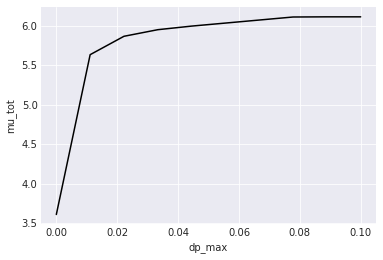

In [297]:
pts = plt.plot('dp_max','mu_tot', data=df_mu_tot, color='#000000')
ax = pts[0].axes
ax.set_xlabel('dp_max')
ax.set_ylabel('mu_tot')